<div style="text-align: center; padding: 20px; background-color: #000000; border-radius: 10px; margin: 20px 0;">
    <h1 style="color: #008080 	;">Data Insights on Spotify using PySpark<h1>
    <hr style="border: 2px solid #008080;">
</div>

### Needed Libraries

In [56]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))
import pyspark as ps
import pyspark.sql.functions as F
from pyspark.sql.functions import explode, desc, countDistinct, count, avg
from pyspark.sql.functions import desc, countDistinct, count
from pyspark.sql.functions import col, when
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import matplotlib.pyplot as plt
from pyspark.sql.functions import floor
from scipy.stats import norm
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import numpy as np

In [57]:
spark = ps.sql.SparkSession.builder \
    .master("local") \
    .appName("spotify") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [58]:
def show_df(df, n=5):
    df.show(n)
    print("number of rows: ",df.count())

### Read From parquet file

In [59]:
spotify_df = spark.read.parquet("spotify.parquet")
show_df(spotify_df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|          loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|            

In [60]:
spotify_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



## Preprocessing

### Data Type Conversion

In [61]:
# mode can be 1 or 0 only
# time signature can be 1, 3, 4, 5
# release date is in the format yyyy-mm-dd
# change the mode column type to boolean
# change the time_signature column type to integer
# change the release_date column type to date


spotify_df = spotify_df.withColumn("explicit", when(spotify_df["explicit"] == True, 1).otherwise(0))
# spotify_df = spotify_df.withColumn("time_signature", spotify_df["time_signature"].cast("integer"))
spotify_df = spotify_df.withColumn("release_date", spotify_df["release_date"].cast("date"))

spotify_df.printSchema()
show_df(spotify_df)


root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: date (nullable = true)



+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|          loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|            

In [62]:
def count_nulls(df):
    null_counts = {col_name: df.where(col(col_name).isNull()).count() for col_name in df.columns}
    for col_name, count in null_counts.items():
        print(f"Column '{col_name}': {count} null values")

count_nulls(spotify_df)

Column 'id': 0 null values
Column 'name': 3 null values
Column 'album': 11 null values
Column 'album_id': 0 null values
Column 'artists': 0 null values
Column 'artist_ids': 0 null values
Column 'track_number': 0 null values
Column 'disc_number': 0 null values
Column 'explicit': 0 null values
Column 'danceability': 0 null values
Column 'energy': 0 null values
Column 'key': 0 null values
Column 'loudness': 0 null values
Column 'mode': 0 null values
Column 'speechiness': 0 null values
Column 'acousticness': 0 null values
Column 'instrumentalness': 0 null values
Column 'liveness': 0 null values
Column 'valence': 0 null values
Column 'tempo': 0 null values
Column 'duration_ms': 0 null values
Column 'time_signature': 0 null values
Column 'year': 0 null values
Column 'release_date': 0 null values


### Number of Songs per year

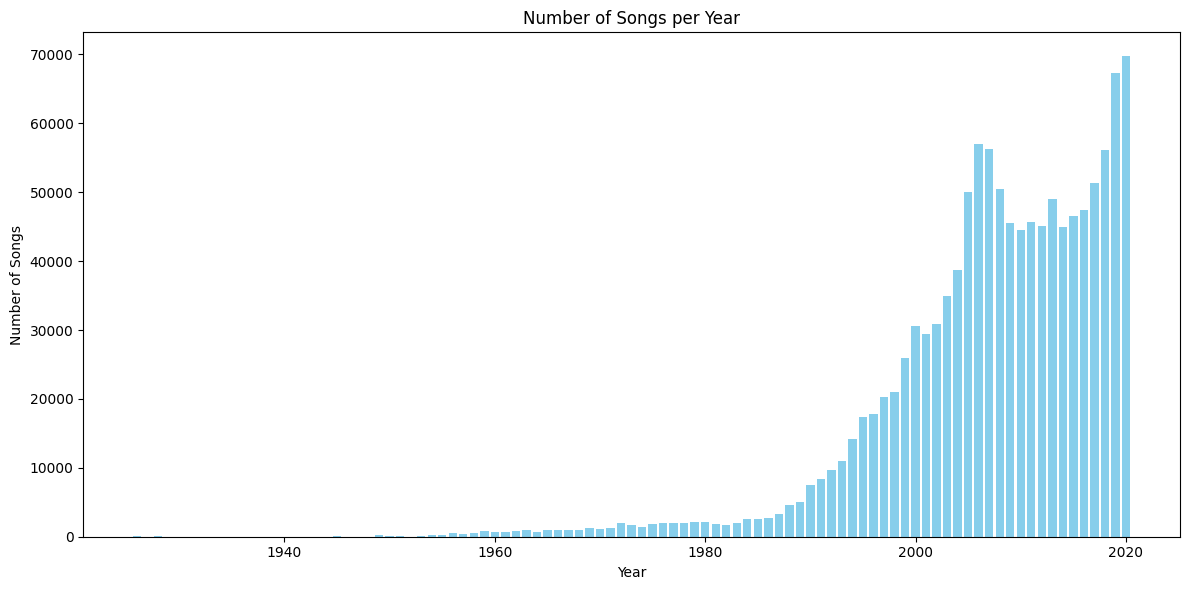

In [63]:
# plot the histogram of year
year_df = spotify_df.groupBy("year").count()
year_df_filtered = year_df.filter(year_df["count"] > 100)

years = year_df_filtered.select("year").rdd.flatMap(lambda x: x).collect()
counts = year_df_filtered.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.bar(years, counts, color='skyblue')
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Year")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

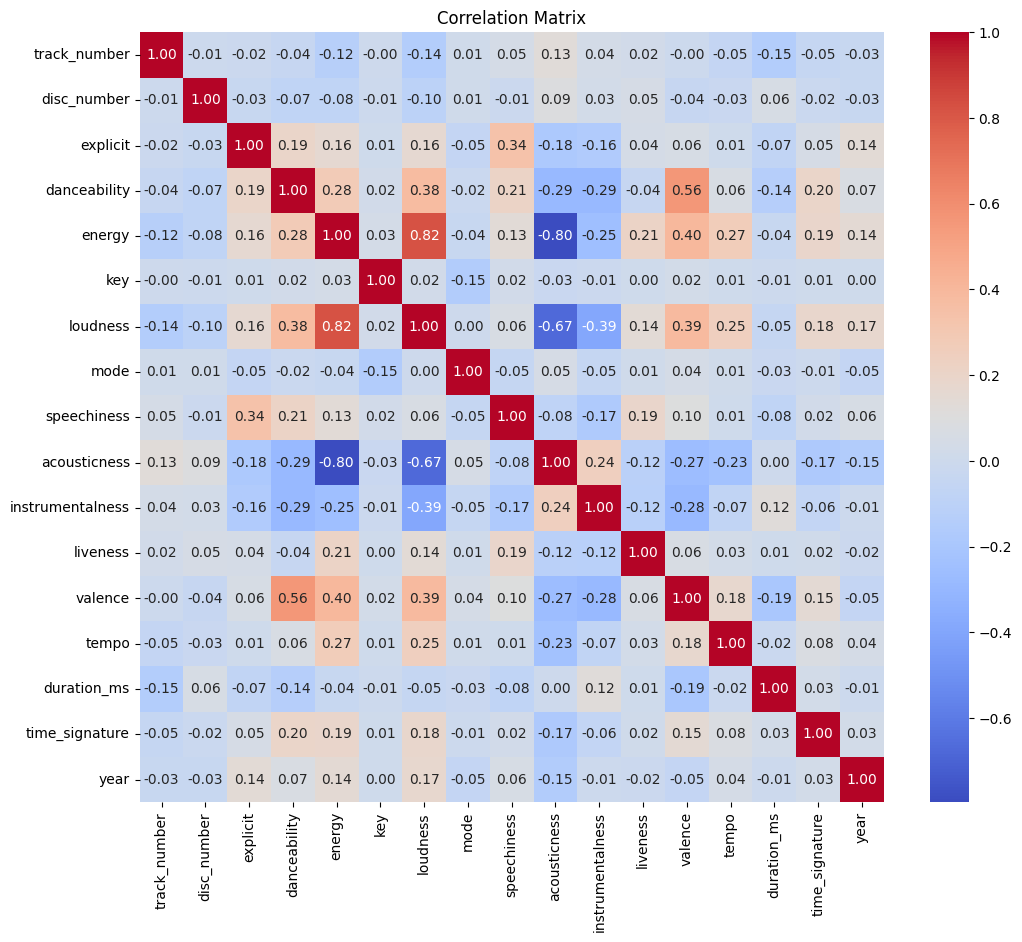

In [64]:
numerical_cols = ["track_number", "disc_number", "explicit", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                  "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature", "year"]


numerical_df = spotify_df.select([col(column) for column in numerical_cols])
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_df = assembler.transform(numerical_df).select("features")

corr_matrix = Correlation.corr(vector_df, "features").head()[0]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.toArray(), annot=True, cmap='coolwarm', fmt=".2f", xticklabels=numerical_cols, yticklabels=numerical_cols)
plt.title('Correlation Matrix')
plt.show()


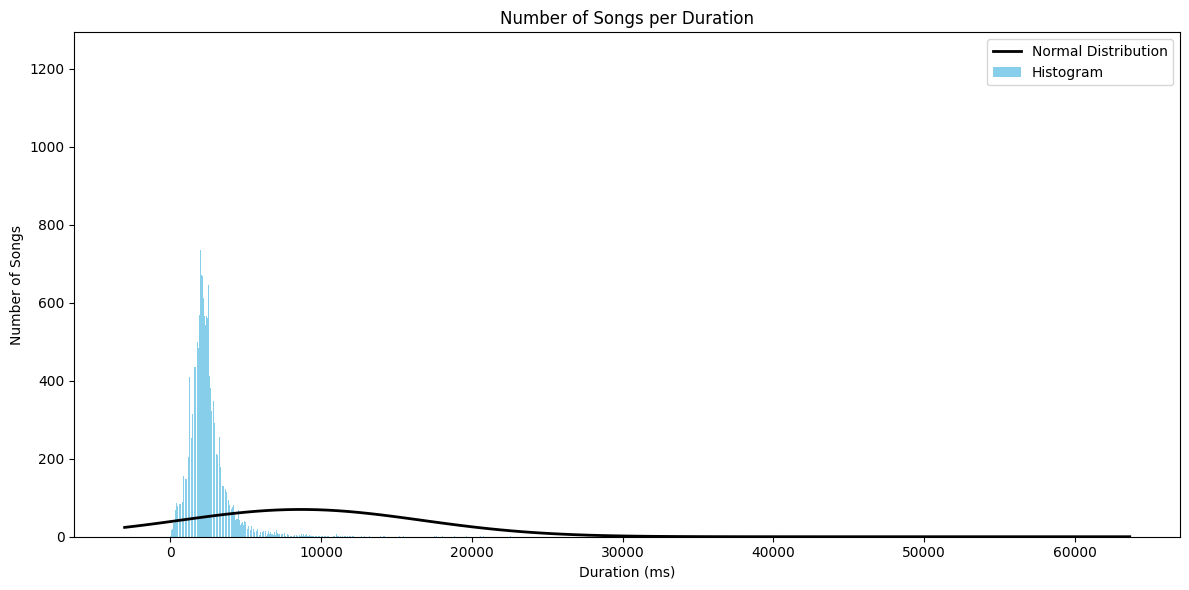

In [65]:
# from pyspark.sql.functions import floor

# bin_width = 100
# filtered_df = spotify_df.filter(spotify_df["duration_ms"] < 200000)
# df_with_groups = spotify_df.withColumn("duration_group", floor(filtered_df["duration_ms"] / bin_width))

# duration_df = df_with_groups.groupBy("duration_group").count()

# x_values = duration_df.select("duration_group").rdd.flatMap(lambda x: x).collect()
# y_values = duration_df.select("count").rdd.flatMap(lambda x: x).collect()

# plt.figure(figsize=(12, 6))
# plt.bar(x_values, y_values, color='skyblue')
# plt.xlabel("Duration (ms)")
# plt.ylabel("Number of Songs")
# plt.title("Number of Songs per Duration")
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()


# Create a SparkSession

# Sample DataFrame with "duration_ms" column
# spotify_df = ...

# # Define the bin width (100 milliseconds)
# bin_width = 100

# # Filter the DataFrame to include only durations less than 200,000 milliseconds
# filtered_df = spotify_df.filter(spotify_df["duration_ms"] < 200000)

# # Create a new column with the duration rounded down to the nearest multiple of 100
# df_with_groups = filtered_df.withColumn("duration_group", floor(filtered_df["duration_ms"] / bin_width))

# # Group by the duration groups and count the number of songs in each group
# duration_df = df_with_groups.groupBy("duration_group").count()

# # Extract the duration groups and counts for plotting
# x_values = duration_df.select("duration_group").rdd.flatMap(lambda x: x).collect()
# y_values = duration_df.select("count").rdd.flatMap(lambda x: x).collect()





bin_width = 100
filtered_df = spotify_df.filter(spotify_df["duration_ms"] < 200000)
df_with_groups = spotify_df.withColumn("duration_group", floor(filtered_df["duration_ms"] / bin_width))

duration_df = df_with_groups.groupBy("duration_group").count()

x_values = duration_df.select("duration_group").rdd.flatMap(lambda x: x).collect()
y_values = duration_df.select("count").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(x_values, y_values, color='skyblue', label="Histogram")

# Fit a normal distribution to the data
mean_duration = np.mean(x_values)
stddev_duration = np.std(x_values)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_duration, stddev_duration) * bin_width * len(x_values)
plt.plot(x, p, 'k', linewidth=2, label="Normal Distribution")

plt.xlabel("Duration (ms)")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Duration")
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

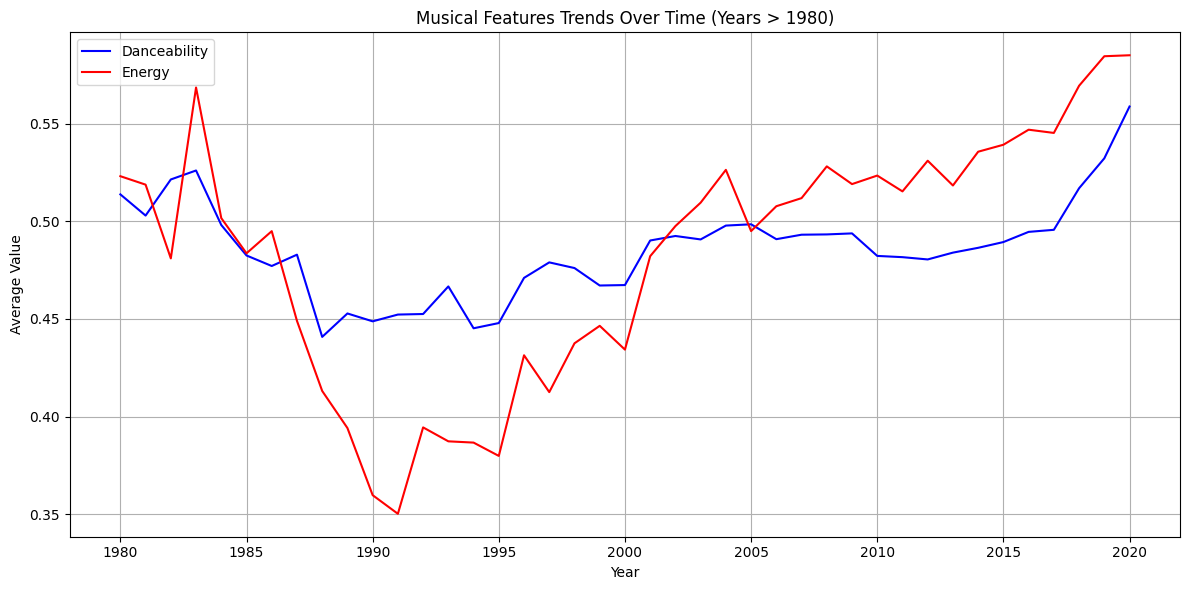

In [66]:
years_more_than_1980 = spotify_df.filter(spotify_df["year"] >= 1980)
yearly_avg_df = years_more_than_1980.groupBy("year").agg(avg("danceability").alias("avg_danceability"),
                                                avg("energy").alias("avg_energy")).orderBy("year")

plt.figure(figsize=(12, 6))

years = yearly_avg_df.select("year").rdd.flatMap(lambda x: x).collect()
avg_danceability = yearly_avg_df.select("avg_danceability").rdd.flatMap(lambda x: x).collect()
avg_energy = yearly_avg_df.select("avg_energy").rdd.flatMap(lambda x: x).collect()

plt.plot(years, avg_danceability, label="Danceability", color="blue")
plt.plot(years, avg_energy, label="Energy", color="red")

plt.xlabel("Year")
plt.ylabel("Average Value")
plt.title("Musical Features Trends Over Time (Years > 1980)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

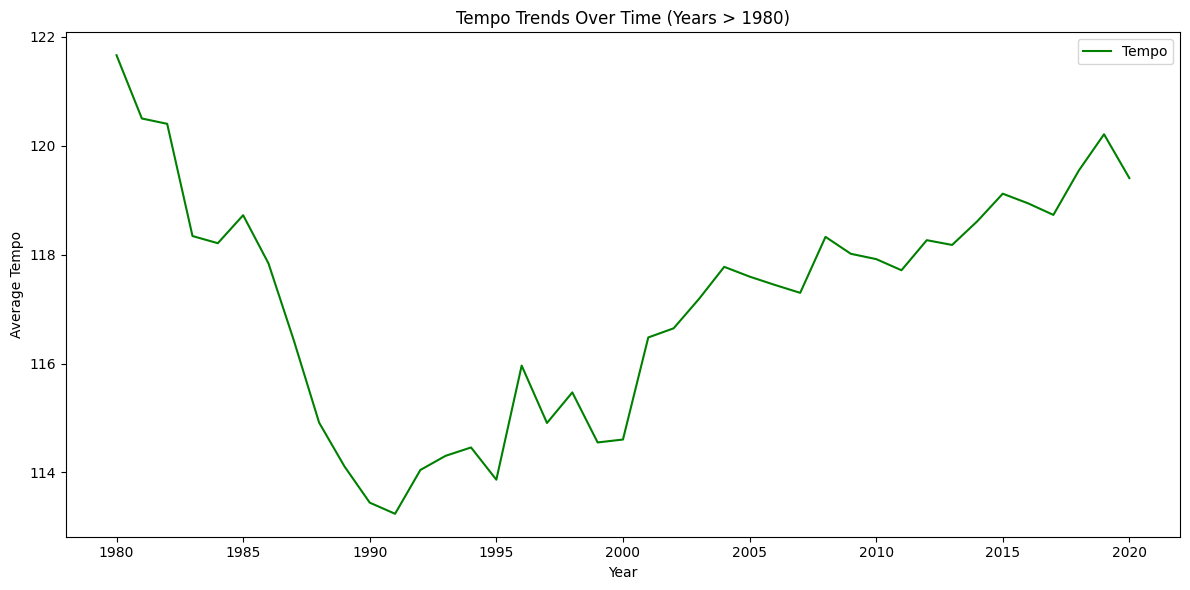

In [67]:
years_more_than_1980 = spotify_df.filter(spotify_df["year"] >= 1980)

yearly_avg_df = years_more_than_1980.groupBy("year").agg(avg("tempo").alias("avg_tempo")).orderBy("year")

plt.figure(figsize=(12, 6))

years = yearly_avg_df.select("year").rdd.flatMap(lambda x: x).collect()
avg_tempo = yearly_avg_df.select("avg_tempo").rdd.flatMap(lambda x: x).collect()

plt.plot(years, avg_tempo, label="Tempo", color="green")
plt.xlabel("Year")
plt.ylabel("Average Tempo")
plt.title("Tempo Trends Over Time (Years > 1980)")
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
def string_to_list(string):
    return string[1:-1].replace("'", "").split(", ")

string_to_list_udf = udf(string_to_list, ArrayType(StringType()))
extended_spotify_df = spotify_df.withColumn("artist_ids", string_to_list_udf("artist_ids"))
extended_spotify_df = extended_spotify_df.withColumn("artists", string_to_list_udf("artists"))

from pyspark.sql.functions import posexplode, arrays_zip



TypeError: 'Column' object is not callable

`Question 1:  Read about how Spark and Hadoop work. What does the term ‘lazy evaluation’ mean
for them? Explain with a simple example.`  
Spark and Hadoop are both frameworks used for big data processing, but they have different architectures and approaches.  
- Hadoop: Hadoop is a distributed computing framework designed to handle large-scale data processing across clusters of commodity hardware. It operates on a master-slave architecture and consists of several key components:  
  &nbsp;&nbsp;&nbsp;&nbsp;Hadoop Distributed File System (HDFS): It stores data in a distributed manner across multiple machines, with replication for fault tolerance. Files in HDFS are divided into blocks, typically 128 MB or 256 MB in size, and distributed across the cluster.  
  &nbsp;&nbsp;&nbsp;&nbsp;MapReduce: MapReduce is a programming model and processing engine used for processing and generating large datasets in parallel across a Hadoop cluster. It divides processing into two phases: Map and Reduce.  
  &nbsp;&nbsp;&nbsp;&nbsp;Yet Another Resource Negotiator (YARN): YARN is the resource management and job scheduling component of Hadoop. It manages resources (CPU, memory) across the cluster and allocates them to running applications.  
- Spark: Spark is a distributed computing framework that provides an in-memory data processing engine, allowing for faster data processing compared to Hadoop MapReduce. It offers a variety of APIs including Scala, Java, Python, and SQL for data processing tasks. Spark operates on Resilient Distributed Datasets (RDDs), which are distributed collections of data that can be cached in memory across a cluster of machines.
- Lazy Evaluation: Lazy evaluation is a programming strategy where an expression is not evaluated until its value is actually needed. In other words, the computation is delayed until the result is required by another part of the program. This approach can lead to efficiency gains by avoiding unnecessary computations, especially in scenarios where the result might not be needed at all or might be needed only partially. In the context of Spark and Hadoop, lazy evaluation means that transformations on data (such as filtering, mapping, or aggregating) are not executed immediately. Instead, they are recorded as a series of transformations on the input data.
Actions, such as collecting data or saving it to disk, trigger the execution of these transformations.
- Example: Consider the following code snippet in Spark using the Python API (PySpark):
```python
# Create an RDD from a list
data = [1, 2, 3, 4, 5]
rdd = spark.sparkContext.parallelize(data)

# Apply transformations (lazy)
transformed_rdd = rdd.filter(lambda x: x % 2 == 0).map(lambda x: x * 2)

# Action: collect the result
result = transformed_rdd.collect()
```
In this example, filter and map are transformations applied to the RDD rdd. These transformations are lazily evaluated, meaning they are not executed immediately. When collect is called, it triggers the execution of the transformations, and the filtered and mapped data is collected and returned as the result.

`Question 2: Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.`
Parquet files offer a highly optimized and scalable solution for storing and processing large datasets.
- Parquet files organize data by column rather than by row. Each column is stored separately, allowing for highly efficient compression and encoding techniques to be applied independently to each column. This columnar storage format reduces the amount of I/O required to read specific columns, leading to faster query performance.
- Parquet files support advanced compression algorithms, which can significantly reduce the storage footprint of the data. This compression reduces disk space usage and I/O operations, making it easier to work with large datasets.
- Parquet files store metadata about the data, such as data types and encoding, within the file itself. This metadata allows for efficient schema evolution and data pruning, enabling faster query execution by skipping irrelevant data.
- Parquet files are splittable, meaning that they can be divided into smaller chunks that can be processed in parallel. This feature allows for parallel processing of data across multiple nodes in a distributed computing environment, improving overall performance.

`Question 3: As you might have noticed, Spark doesn’t save checkpoints. How can we enforce it to do so? This can help us if we have multiple computation steps and we don’t want to wait a lot for the result.`  
In Spark, you can enforce checkpointing to save intermediate RDDs to disk by using the checkpoint() method. Before performing any operations that require checkpointing, we need to enable checkpointing in our SparkSession.
```python
spark.sparkContext.setCheckpointDir("hdfs://path/to/checkpoint_directory")
```
After enabling checkpointing, we can call the checkpoint() method on an RDD to trigger the checkpointing process.
```python
transformed_rdd.checkpoint()
```

`Question 4: Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?`
To save data in a way that allows for faster filtering based on specific columns, we can use partitioning. Storing the streaming data in a columnar format rather than a row-based format can improve query performance, especially when filtering based on specific columns like date. Also partitioning the data based on the column(s) we want to filter on can redduce the amount of data that needs to be scanned during filtering operations. For example, if we partition the data by date, we can quickly filter the data based on the date column without scanning the entire dataset.

`Question 5: Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why? Consider factors like data size, processing complexity, and user experience.`
- Data Size: Pandas is well-suited for working with small to medium-sized datasets that can fit into memory on a single machine. On the other hand, PySpark is designed for processing large-scale datasets that are distributed across a cluster of machines, allowing for parallel processing and scalability.
- Processing Complexity: Pandas is ideal for interactive data analysis and exploration, as it provides a rich set of data manipulation and analysis tools. It is well-suited for complex data transformations, feature engineering, and statistical analysis. PySpark, on the other hand, is optimized for data processing tasks like ETL (Extract, Transform, Load), machine learning, and graph processing and provides rich set of APIs.
- User Experience: Pandas offers a user-friendly and intuitive interface for data analysis, It's syntax is easy to understand and use. PySpark, on the other hand, has a steeper learning curve due to its distributed nature and the need to understand concepts like RDDs, transformations, and actions. Also the syntax is less intuitive compared to Pandas.  

PySpark shines when it comes to scalability. This scalability makes PySpark ideal for big data analytics in production environments. In the realm of data manipulation and exploration, Pandas library shines as a versatile tool. The ability to handle complex data structures is crucial, especially when dealing with datasets that involve nested lists
